
# IMT-342 Robótica — Cuaderno 1  
## **Cinemática y Transformadas Espaciales**

**Docente:** Ing. Kaleb Irahola Azad  
**Carrera:** Ingeniería Mecatrónica — UCB Tarija  


> Este cuaderno está alineado con el *Tema 1* del Plan de Asignatura IMT-342: **Modelado de robots, transformadas espaciales y cinemática directa**.



## Estructura del cuaderno

1. **Introducción**
2. **Fundamentos matemáticos**
   - Vectores, bases y cambios de coordenadas
   - Matrices de rotación (SO(3))
   - Transformaciones homogéneas (SE(3))
   - ➤ *Ejercicio 1: Rotación de un vector y verificación de propiedades*
3. **Transformaciones espaciales** (orden y convenciones)
   - Mundo fijo vs cuerpo fijo  
   - ➤ *Demo gráfica del orden de multiplicación*
4. **Parámetros de Denavit–Hartenberg (DH)**
   - Definición y matriz elemental (DH estándar)
   - ➤ *Ejercicio 2: 2R planar con DH*
5. **Cinemática directa**
   - 2R planar (geométrica y DH)
   - 3R planar (ejemplo)
   - ➤ *Ejercicio 3: comparación geométrica vs DH*
6. **Orientación y composición de rotaciones**
   - No conmutatividad en 3D
   - ➤ *Ejercicio 4: demostrar no conmutatividad*
7. **Visualización 3D de marcos encadenados**
   - Funciones utilitarias de dibujo
   - ➤ *Ejercicio 5: 2R espacial simple (α≠0)*
8. **Buenas prácticas para evitar confusiones de orden**
9. **Apéndice — Bibliografía breve**



## 1. Introducción

La **cinemática** estudia la geometría del movimiento sin considerar fuerzas. En manipuladores robóticos, las preguntas clave son:
- **Cinemática directa (FK):** dados los **ángulos articulares** (o desplazamientos prismáticos), ¿cuál es la **pose** (posición y orientación) del efector final?
- **Cinemática inversa (IK):** dada una pose deseada, ¿qué valores articulares logran esa pose?

En este cuaderno nos enfocamos en **FK**, transformadas espaciales (SE(3)) y el **modelo DH**.



## 2. Fundamentos matemáticos (recordatorio rápido)

### 2.1 Vectores y bases
Un vector en $\mathbb{R}^3$ puede escribirse como $\mathbf{p} = [x\ y\ z]^T$ respecto de una base $\{\hat{\mathbf{x}},\hat{\mathbf{y}},\hat{\mathbf{z}}\}$.  
Cambiar de base implica **rotar** y **trasladar** coordenadas.

### 2.2 Matrices de rotación (SO(3))
Una matriz de rotación $R \in \mathrm{SO}(3)$ cumple $R^TR = I$ y $\det(R)=1$.  
Rotaciones elementales:
$$
R_x(\alpha)=\begin{bmatrix}
1&0&0\\
0&\cos\alpha&-\sin\alpha\\
0&\sin\alpha&\cos\alpha
\end{bmatrix},\quad
R_y(\beta)=\begin{bmatrix}
\cos\beta&0&\sin\beta\\
0&1&0\\
-\sin\beta&0&\cos\beta
\end{bmatrix},\quad
R_z(\gamma)=\begin{bmatrix}
\cos\gamma&-\sin\gamma&0\\
\sin\gamma&\cos\gamma&0\\
0&0&1
\end{bmatrix}
$$


### 2.3 Coordenadas homogéneas y transformadas rígidas (SE(3))
La pose (rotación + traslación) se representa como:
$$
T=\begin{bmatrix}
R & \mathbf{p}\\
\mathbf{0}^{\top} & 1
\end{bmatrix}\in SE(3),\qquad
\mathbf{p}\in\mathbb{R}^3,\; R\in SO(3).
$$


La composición de transformaciones es **asociativa**: $T_{ac}=T_{ab}T_{bc}$. El **orden** importa.


In [9]:
# === Librerías base ===
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from typing import List, Tuple
import spatialmath as sm
import roboticstoolbox as rtb
print('spatialmath', sm.__version__)
print('roboticstoolbox', rtb.__version__)

AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

In [ ]:

# Configuración general de Matplotlib (sin estilos ni colores específicos)
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = True

# === Operadores y transformaciones homogéneas ===
def Rx(alpha: float) -> np.ndarray:
    c, s = np.cos(alpha), np.sin(alpha)
    R = np.array([[1, 0, 0],
                  [0, c, -s],
                  [0, s,  c]])
    T = np.eye(4); T[:3,:3] = R
    return T

def Ry(beta: float) -> np.ndarray:
    c, s = np.cos(beta), np.sin(beta)
    R = np.array([[ c, 0, s],
                  [ 0, 1, 0],
                  [-s, 0, c]])
    T = np.eye(4); T[:3,:3] = R
    return T

def Rz(gamma: float) -> np.ndarray:
    c, s = np.cos(gamma), np.sin(gamma)
    R = np.array([[c, -s, 0],
                  [s,  c, 0],
                  [0,  0, 1]])
    T = np.eye(4); T[:3,:3] = R
    return T

def Tx(a: float) -> np.ndarray:
    T = np.eye(4); T[0,3] = a; return T

def Ty(b: float) -> np.ndarray:
    T = np.eye(4); T[1,3] = b; return T

def Tz(c: float) -> np.ndarray:
    T = np.eye(4); T[2,3] = c; return T

def is_rotation_matrix(R: np.ndarray, atol: float = 1e-9) -> bool:
    # Verifica ortonormalidad y det=1 para R de 3x3
    if R.shape != (3,3): return False
    should_be_I = R.T @ R
    I = np.eye(3)
    return np.allclose(should_be_I, I, atol=atol) and np.isclose(np.linalg.det(R), 1.0, atol=atol)

def pose_from_T(T: np.ndarray):
    # Retorna (R, p) desde T
    return T[:3,:3], T[:3,3]

def draw_frame(ax, T: np.ndarray, label: str = "", scale: float = 1.0):
    # Dibuja ejes de un marco de referencia a partir de T (homogénea).
    o = T[:3, 3]
    x = o + scale * T[:3, 0]
    y = o + scale * T[:3, 1]
    z = o + scale * T[:3, 2]
    ax.plot([o[0], x[0]], [o[1], x[1]], [o[2], x[2]])
    ax.plot([o[0], y[0]], [o[1], y[1]], [o[2], y[2]])
    ax.plot([o[0], z[0]], [o[1], z[1]], [o[2], z[2]])
    if label:
        ax.text(o[0], o[1], o[2], label)



### 🧪 Ejercicio 1 — Rotación de un vector y verificación de propiedades

1. Define un vector $\mathbf{p}=[1,2,3]^T$.
2. Rota el vector con $R_z(\pi/4)$ y obtén $\mathbf{p}'$ (usa homogénea o rotación pura).
3. Verifica que $R^TR=I$ y que $\| \mathbf{p}' \| = \| \mathbf{p} \|$.


In [3]:

# === Solución guiada (puedes modificar y experimentar) ===
p = np.array([1.0, 2.0, 3.0])
T = Rz(np.pi/4)
R, t = pose_from_T(T)

# Verificaciones
print("¿R es rotación válida?", is_rotation_matrix(R))
p_rot = R @ p
print("p' =", p_rot)
print("||p|| = ", np.linalg.norm(p), " ||p'|| = ", np.linalg.norm(p_rot))


¿R es rotación válida? True
p' = [-0.70710678  2.12132034  3.        ]
||p|| =  3.7416573867739413  ||p'|| =  3.7416573867739413



## 3. Transformaciones espaciales y **orden** de multiplicación

Sea un punto expreso en el marco **B** y queremos su coordenada en **A**. Si $T_{AB}$ lleva de B a A,
entonces $\mathbf{p}_A = T_{AB}\,\mathbf{p}_B$ (en homogéneas).

**Convenciones**:
- **Mundo fijo (pre-multiplicación)**: $T \leftarrow T \cdot T_{\text{nueva}}$ (aplica en el marco mundo).
- **Cuerpo fijo (post-multiplicación)**: $T \leftarrow T_{\text{nueva}} \cdot T$ (aplica en el marco móvil).

A continuación, comparamos ambas interpretaciones gráficamente.


T (mundo fijo):
 [[ 0.70710678 -0.70710678  0.          1.41421356]
 [ 0.70710678  0.70710678  0.          1.41421356]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]

T (cuerpo fijo):
 [[ 0.70710678 -0.70710678  0.          1.41421356]
 [ 0.70710678  0.70710678  0.          1.41421356]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


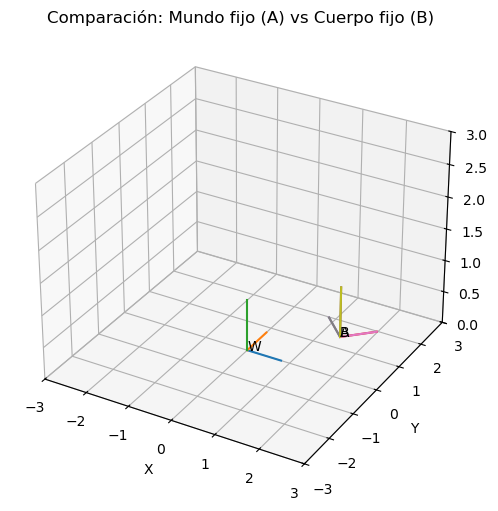

In [4]:

# === Demostración del orden de multiplicación ===
def sequence_world_fixed():
    T = np.eye(4)
    T = T @ Rz(np.pi/4)  # rotar en mundo
    T = T @ Tx(2.0)      # trasladar en mundo
    return T

def sequence_body_fixed():
    T = np.eye(4)
    T = Tx(2.0) @ T      # trasladar en cuerpo
    T = Rz(np.pi/4) @ T  # rotar en cuerpo
    return T

Ta = sequence_world_fixed()
Tb = sequence_body_fixed()

print("T (mundo fijo):\n", Ta)
print("\nT (cuerpo fijo):\n", Tb)

# Visualización 3D de marcos
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3,3]); ax.set_ylim([-3,3]); ax.set_zlim([0,3])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
draw_frame(ax, np.eye(4), 'W', 0.8)
draw_frame(ax, Ta, 'A', 0.8)
draw_frame(ax, Tb, 'B', 0.8)
plt.title("Comparación: Mundo fijo (A) vs Cuerpo fijo (B)")
plt.show()



## 4. Parámetros de Denavit–Hartenberg (DH)

Para cada par de eslabones, los parámetros estándar DH son: $a_i, \alpha_i, d_i, \theta_i$.  
La matriz elemental (convención **estándar**) es:
$$
A_i = \begin{bmatrix}
\cos\theta_i & -\sin\theta_i\cos\alpha_i & \sin\theta_i\sin\alpha_i & a_i\cos\theta_i \\
\sin\theta_i & \cos\theta_i\cos\alpha_i  & -\cos\theta_i\sin\alpha_i & a_i\sin\theta_i \\
0            & \sin\alpha_i              & \cos\alpha_i              & d_i \\
0            & 0                         & 0                         & 1
\end{bmatrix}
$$


> **Nota:** Existen variantes (DH estándar vs. modificada). Aquí usamos **DH estándar**.


In [5]:

# === Implementación DH (estándar) ===
def DH(a: float, alpha: float, d: float, theta: float) -> np.ndarray:
    ca, sa = np.cos(alpha), np.sin(alpha)
    ct, st = np.cos(theta), np.sin(theta)
    return np.array([
        [ct, -st*ca,  st*sa, a*ct],
        [st,  ct*ca, -ct*sa, a*st],
        [ 0,     sa,     ca,    d],
        [ 0,      0,      0,    1]
    ], dtype=float)

def fkine_DH(params: List[Tuple[float, float, float, float]]) -> np.ndarray:
    # params = [(a1,alpha1,d1,theta1), ...]
    T = np.eye(4)
    for (a, alpha, d, theta) in params:
        T = T @ DH(a, alpha, d, theta)
    return T



### 🧪 Ejercicio 2 — DH de un 2R planar

Para un manipulador **planar 2R** (dos juntas rotatorias en el plano XY) con longitudes $L_1, L_2$:
- Propón los parámetros DH estándar apropiados.
- Implementa la **cinemática directa** con `fkine_DH`.
- Grafica la configuración para un par $(q_1, q_2)$.

> **Sugerencia:** en un 2R planar $\alpha_i=0$ y $d_i=0$ suelen ser elecciones válidas.


In [ ]:

# === Solución guiada 2R ===
L1, L2 = 1.0, 1.0
def dh_2R(q1: float, q2: float):
    # (a, alpha, d, theta) por eslabón
    p1 = (L1, 0.0, 0.0, q1)
    p2 = (L2, 0.0, 0.0, q2)
    return [p1, p2]

def plot_2R(q1: float, q2: float, L1: float=1.0, L2: float=1.0):
    # Kinemática directa simple (geométrica 2D)
    x0, y0 = 0.0, 0.0
    x1, y1 = L1*np.cos(q1), L1*np.sin(q1)
    x2, y2 = x1 + L2*np.cos(q1+q2), y1 + L2*np.sin(q1+q2)

    plt.figure()
    plt.plot([x0,x1,x2],[y0,y1,y2], '-o', linewidth=2)
    plt.axis('equal'); plt.xlabel('X'); plt.ylabel('Y')
    plt.title(f'2R: q1={q1:.2f}, q2={q2:.2f}')
    plt.show()

# Ejemplo
q1, q2 = np.deg2rad(45), np.deg2rad(30)
T_2R = fkine_DH(dh_2R(q1, q2))
print("T_efector (2R):\n", T_2R)
plot_2R(q1, q2, L1, L2)



## 5. Cinemática directa

### 5.1 2R: comparación geométrica vs DH
Para 2R planar, la posición del efector puede obtenerse geométricamente:
\[
x = L_1\cos q_1 + L_2\cos(q_1+q_2),\quad
y = L_1\sin q_1 + L_2\sin(q_1+q_2).
\]
La orientación es $\theta = q_1 + q_2$.

### 5.2 3R planar (ejemplo)
Manteniendo $\alpha_i=0$ y $d_i=0$, se obtiene un manipulador planar 3R (todas las rotaciones alrededor de $z$).


In [ ]:

# === 3R planar (ejemplo sencillo) ===
L1, L2, L3 = 1.0, 0.8, 0.6

def dh_3R(q1: float, q2: float, q3: float):
    p1 = (L1, 0.0, 0.0, q1)
    p2 = (L2, 0.0, 0.0, q2)
    p3 = (L3, 0.0, 0.0, q3)
    return [p1, p2, p3]

def plot_3R(q1: float, q2: float, q3: float, L1=1.0, L2=0.8, L3=0.6):
    # Geométrica 2D
    x0, y0 = 0.0, 0.0
    x1, y1 = L1*np.cos(q1), L1*np.sin(q1)
    x2, y2 = x1 + L2*np.cos(q1+q2), y1 + L2*np.sin(q1+q2)
    x3, y3 = x2 + L3*np.cos(q1+q2+q3), y2 + L3*np.sin(q1+q2+q3)

    plt.figure()
    plt.plot([x0,x1,x2,x3],[y0,y1,y2,y3], '-o', linewidth=2)
    plt.axis('equal'); plt.xlabel('X'); plt.ylabel('Y')
    plt.title(f'3R: q=[{q1:.2f}, {q2:.2f}, {q3:.2f}]')
    plt.show()

q = np.deg2rad([30, 20, -40])
T_3R = fkine_DH(dh_3R(*q))
print("T_efector (3R):\n", T_3R)
plot_3R(*q, L1, L2, L3)



### 🧪 Ejercicio 3 — Comparación geométrica vs DH (2R)

1. Implementa una función `fk_geom_2R(q1,q2,L1,L2)` que retorne $(x,y,\theta)$.
2. Compara la pose obtenida geométricamente versus la extraída de `T_2R` (usa `np.arctan2` para el ángulo).
3. Verifica la **consistencia numérica**.


In [ ]:

# === Espacio para tu solución ===
def fk_geom_2R(q1, q2, L1=1.0, L2=1.0):
    x = L1*np.cos(q1) + L2*np.cos(q1+q2)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2)
    theta = q1 + q2
    return x, y, theta

# Prueba rápida: compara contra DH
q1, q2 = np.deg2rad(45), np.deg2rad(30)
xg, yg, thg = fk_geom_2R(q1, q2, L1=1.0, L2=1.0)
T = fkine_DH(dh_2R(q1,q2))
xT, yT = T[0,3], T[1,3]
thT = np.arctan2(T[1,0], T[0,0])  # ángulo en plano
print("Geom:", xg, yg, thg, "\nDH  :", xT, yT, thT)



## 6. Orientación y composición de rotaciones

El orden de rotaciones **no conmutan** en 3D: en general $R_x(\alpha)R_y(\beta) \neq R_y(\beta)R_x(\alpha)$.  
Esto es clave para interpretar correctamente secuencias de Euler u otros esquemas.

### 🧪 Ejercicio 4 — No conmutatividad
1. Calcula $R_1 = R_x(\alpha)R_y(\beta)$ y $R_2 = R_y(\beta)R_x(\alpha)$ con $\alpha=\beta=\pi/4$.
2. Verifica que $R_1\neq R_2$ y aplica ambos a un mismo vector para comparar.


In [ ]:

# === Solución guiada ===
alpha = beta = np.pi/4
R1 = (Rx(alpha) @ Ry(beta))[:3,:3]
R2 = (Ry(beta) @ Rx(alpha))[:3,:3]

print("R1=\n", R1, "\n\nR2=\n", R2)
print("\n¿Son iguales? ->", np.allclose(R1, R2))

# Demostración con un vector
v = np.array([1.0, 0.0, 0.0])
v1 = R1 @ v
v2 = R2 @ v
print("v1=", v1, "  v2=", v2)



## 7. Visualización 3D de marcos encadenados

Dibujamos los marcos $\{0\},\{1\},\{2\},\ldots$ a partir de una lista de transformaciones homogéneas.
Esto ayuda a **interpretar físicamente** el encadenamiento y la orientación resultante.


In [ ]:

def cumulative_T_list(params: List[Tuple[float, float, float, float]]) -> List[np.ndarray]:
    Ts = [np.eye(4)]
    T = np.eye(4)
    for p in params:
        T = T @ DH(*p)
        Ts.append(T.copy())
    return Ts

def plot_frames_3D(Ts: List[np.ndarray], scale: float = 0.5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_xlim([-2, 2]); ax.set_ylim([-2, 2]); ax.set_zlim([-2, 2])
    for i, T in enumerate(Ts):
        draw_frame(ax, T, f"{i}", scale)
    plt.title("Marcos encadenados (DH)")
    plt.show()

# Ejemplo con 3R
Ts = cumulative_T_list(dh_3R(*np.deg2rad([20, 35, -15])))
plot_frames_3D(Ts, scale=0.4)



### 🧪 Ejercicio 5 — DH **espacial** simple (α≠0)

Plantea un **2R espacial** donde:
- La primera junta rota alrededor de $z_0$.
- El segundo eje **no es colineal** con el primero: usa $\alpha_2=\pm \pi/2$ y $a_2\neq 0$.

1. Define $(a_i,\alpha_i,d_i,\theta_i)$ para ambos eslabones.
2. Usa `cumulative_T_list` y `plot_frames_3D` para visualizar los marcos.
3. Describe cómo cambia la orientación al variar $q_2$.



## 8. Buenas prácticas para evitar confusiones de orden

- **Dibuja** siempre los marcos y ejes de rotación.
- **Anota** si tus transformaciones se interpretan en **marco mundo** o **marco cuerpo**.
- **Agrupa** transformaciones en bloques lógicos (ej.: “muñeca” del robot).
- **Valida** ortonormalidad: $R^TR=I$ (`is_rotation_matrix`).
- **Comenta** el **orden** de tus multiplicaciones y por qué.



## 9. Apéndice — Bibliografía breve

- K. M. Lynch, F. C. Park, *Modern Robotics: Mechanics, Planning, and Control*, 2017.  
- M. W. Spong, S. Hutchinson, M. Vidyasagar, *Robot Modeling and Control*, 2006.

> Este cuaderno está alineado con la Unidad 1 del Plan de Asignatura IMT-342: **Fundamentos y modelado de robots; transformadas espaciales; cinemática directa**.
